## About This Notebook

This notebook serves as an explainer and companion to the final data story project for the *Social Data Analysis and Visualization* course.

Authors - *Group 29*

- Souar Ramzi Mohammad Ali – *s191446*  
- Kovács, Eszter – *s233083*  
- Gyöngyösi, Márk – *s232976*


## Motivation

We are using two datasets from NYC OpenData: one containing [EMS (Emergency Medical Services) emergencies](https://data.cityofnewyork.us/Public-Safety/EMS-Incident-Dispatch-Data/76xm-jjuj) and another detailing [Fire incidents](https://data.cityofnewyork.us/Public-Safety/EMS-Incident-Dispatch-Data/76xm-jjuj/about_data).

We chose these datasets because of the shared attributes that make it possible to contrast response patterns and geographic distributions. The similarities between the two datasets make it easy to merge them into a larger dataset. This is especially meaningful given that EMS and fire emergencies often occur together.

Our goal was to offer the end user an understanding of how emergency response services function in an amazingly complex urban setting like New York City. It’s fascinating how, despite the city’s scale, density, and constant traffic, response times can still be measured in seconds.

Disclaimer: The data were generated by the Starfire and EMS CAD systems. Due to HIPAA regulations, exact locations of incidents are not included and have been aggregated to the ZIP code level.



In [1]:
import pandas as pd
import folium
import geopandas as gpd
from folium import GeoJson
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import output_file, save


## Understanding the Datasets

### Data Size and Preprocessing

Both datasets are large and require substantial cleaning and preprocessing:

- **Fire dataset**: 11.1 million rows and 29 columns, with many redundant or irrelevant columns.
- **EMS dataset**: 28 million rows and 31 columns, again, much of the data is redundant or irrelevant to our analysis.

Given the large size of the datasets, optimizing the data for processing is essential. A significant amount of data cleaning was made.

### Preprocessing and Data Cleaning Choices

1. **Column Removal**:
   - Both datasets contain many columns that are not useful for our analysis, such as those related administrative details. These columns were removed to focus on the most relevant fields, like `INCIDENT_DATETIME`, `ZIPCODE`, `BOROUGH`, and `SEVERITY_CATEGORY`.

2. **Handling Missing Data**:
   - We dealt with missing or NaN values by removing rows as the amount of data loss was acceptable .

3. **Mapping Zipcodes**:
   - In the US Zipcode system, codes can be mapped to Lat-Long coordiantes, we used a csv found online to find out about the geopgraphical location of incidents.

4. **Type Formatting**:
   - As both datasets have similar fields, we often formatted problematic types, such as date to remove the possibility of errors.


### Exploratory Data Analysis - Key Observations

- The data is spanning multiple years, but requires substantial preprocessing to remove redundancies and irrelevant information.
- Despite the lack of exact location data, ZIP code aggregation is enough for analysis of incident distribution across the city.
- The datasets have similar structures, making it possible to merge the two datasets.
- There is a considerable amount of missing values, luckily there is plenty of data and much of the columns are dropped anyways 
- Performance is a huge challenge with this amount of data, strictly not needed columns are dropped.

In [2]:
ems_df = pd.read_csv('EMS.csv')
fire_df = pd.read_csv('FI.csv')

C:\Users\Kaiusz Prime\AppData\Local\Temp\ipykernel_17268\2243468388.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  fire_df = pd.read_csv('FI.csv')


In [3]:
# Columns to drop
cols_to_drop_ems_df = [
    'FIRST_TO_HOSP_DATETIME', 'FIRST_HOSP_ARRIVAL_DATETIME', 'HELD_INDICATOR',
    'REOPEN_INDICATOR', 'SPECIAL_EVENT_INDICATOR', 'STANDBY_INDICATOR',
    'TRANSFER_INDICATOR', 'INITIAL_SEVERITY_LEVEL_CODE', 'INITIAL_CALL_TYPE',
    'CITYCOUNCILDISTRICT', 'INCIDENT_DISPOSITION_CODE', 'VALID_DISPATCH_RSPNS_TIME_INDC',
    'COMMUNITYDISTRICT', 'FIRST_ACTIVATION_DATETIME', 'FIRST_ON_SCENE_DATETIME',
    'COMMUNITYSCHOOLDISTRICT', 'VALID_INCIDENT_RSPNS_TIME_INDC', 'INCIDENT_TRAVEL_TM_SECONDS_QY',
    'CONGRESSIONALDISTRICT', 'INCIDENT_CLOSE_DATETIME', 'INCIDENT_DISPATCH_AREA', 'DISPATCH_RESPONSE_SECONDS_QY'
]
ems_df = ems_df.drop(columns=cols_to_drop_ems_df, errors='ignore')

cols_to_drop_fire_df = [
    'ENGINES_ASSIGNED_QUANTITY', 'LADDERS_ASSIGNED_QUANTITY',
    'OTHER_UNITS_ASSIGNED_QUANTITY', 'ALARM_BOX_NUMBER', 'ALARM_BOX_LOCATION',
    'ALARM_LEVEL_INDEX_DESCRIPTION', 'ALARM_BOX_BOROUGH',
    'CITYCOUNCILDISTRICT', 'FIRST_ACTIVATION_DATETIME', 'FIRST_ON_SCENE_DATETIME'
    'COMMUNITYDISTRICT', 'INCIDENT_CLOSE_DATETIME','VALID_DISPATCH_RSPNS_TIME_INDC',
    'COMMUNITYSCHOOLDISTRICT', 'VALID_INCIDENT_RSPNS_TIME_INDC',
    'CONGRESSIONALDISTRICT', 'INCIDENT_TRAVEL_TM_SECONDS_QY',
    'FIRST_ASSIGNMENT_DATETIME', 'DISPATCH_RESPONSE_SECONDS_QY'


]
fire_df= fire_df.drop(columns=cols_to_drop_fire_df, errors='ignore')


#renaming
ems_df = ems_df.rename(columns={
    'CAD_INCIDENT_ID': 'INCIDENT_ID'
})

fire_df = fire_df.rename(columns={
    'STARFIRE_INCIDENT_ID': 'INCIDENT_ID',
    'INCIDENT_BOROUGH': 'BOROUGH'
})

#reordering columns
common_cols = [
    'INCIDENT_ID',
    'INCIDENT_DATETIME',
    'BOROUGH',
    'ZIPCODE',
    'POLICEPRECINCT',
    'INCIDENT_RESPONSE_SECONDS_QY',
]

ems_extra = [
    'FINAL_SEVERITY_LEVEL_CODE',
    'FINAL_CALL_TYPE',
]

fire_extra = [
    'HIGHEST_ALARM_LEVEL',
    'INCIDENT_CLASSIFICATION_GROUP',
    'INCIDENT_CLASSIFICATION'
]

# Reorder EMS DataFrame
ems_df = ems_df[[col for col in common_cols + ems_extra if col in ems_df.columns]]

# Reorder FIRE DataFrame
fire_df = fire_df[[col for col in common_cols + fire_extra if col in fire_df.columns]]


EMS Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27223682 entries, 0 to 27223681
Data columns (total 8 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   INCIDENT_ID                   int64  
 1   INCIDENT_DATETIME             object 
 2   BOROUGH                       object 
 3   ZIPCODE                       float64
 4   POLICEPRECINCT                float64
 5   INCIDENT_RESPONSE_SECONDS_QY  float64
 6   FINAL_SEVERITY_LEVEL_CODE     int64  
 7   FINAL_CALL_TYPE               object 
dtypes: float64(3), int64(2), object(3)
memory usage: 1.6+ GB
None

Fire Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11131079 entries, 0 to 11131078
Data columns (total 9 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   INCIDENT_ID                    object 
 1   INCIDENT_DATETIME              object 
 2   BOROUGH                        object 
 3   ZIPCODE               

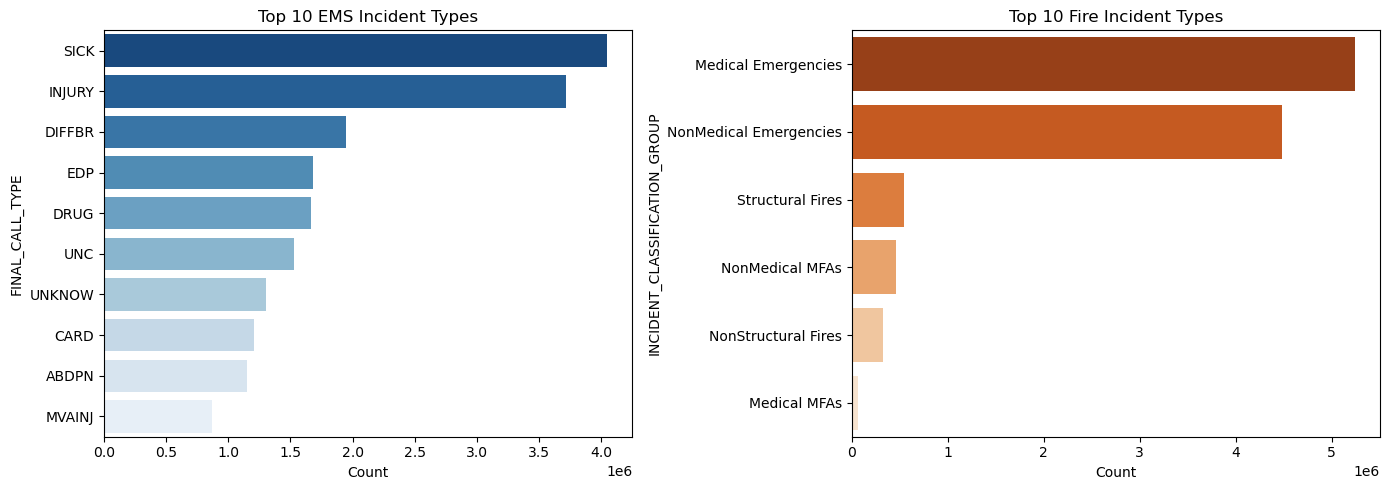

Missing values in EMS dataset:
INCIDENT_RESPONSE_SECONDS_QY    995019
ZIPCODE                         550253
POLICEPRECINCT                  549282
INCIDENT_ID                          0
INCIDENT_DATETIME                    0
BOROUGH                              0
FINAL_SEVERITY_LEVEL_CODE            0
FINAL_CALL_TYPE                      0
dtype: int64

Missing values in Fire dataset:
ZIPCODE                          666341
POLICEPRECINCT                   665843
INCIDENT_RESPONSE_SECONDS_QY     631607
INCIDENT_ID                          20
INCIDENT_DATETIME                     0
BOROUGH                               0
HIGHEST_ALARM_LEVEL                   0
INCIDENT_CLASSIFICATION_GROUP         0
INCIDENT_CLASSIFICATION               0
dtype: int64


In [4]:
print("EMS Dataset:")
print(ems_df.info())
print("\nFire Dataset:")
print(fire_df.info())

# Top incident types
top_ems_types = ems_df['FINAL_CALL_TYPE'].value_counts().head(10)
top_fire_types = fire_df['INCIDENT_CLASSIFICATION_GROUP'].value_counts().head(10)

# Plot top incident types
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(x=top_ems_types.values, y=top_ems_types.index, ax=axs[0], palette='Blues_r')
axs[0].set_title("Top 10 EMS Incident Types")
axs[0].set_xlabel("Count")

sns.barplot(x=top_fire_types.values, y=top_fire_types.index, ax=axs[1], palette='Oranges_r')
axs[1].set_title("Top 10 Fire Incident Types")
axs[1].set_xlabel("Count")

plt.tight_layout()
plt.show()

# Check for missing values
print("Missing values in EMS dataset:")
print(ems_df.isnull().sum().sort_values(ascending=False).head(10))

print("\nMissing values in Fire dataset:")
print(fire_df.isnull().sum().sort_values(ascending=False).head(10))

We noticed that some ZIPCode values are missing, which is important since we use ZIPCodes to match with latitude and longitude coordinates for mapping. About 2% and 6% is missing in the respective data sets. Given that, the data quality is still acceptable for our purposes.

In [5]:
fire_df.head()

INCIDENT_ID       INCIDENT_DATETIME                   BOROUGH  ZIPCODE  \
0  500127850130001  01/01/2005 12:00:01 AM  RICHMOND / STATEN ISLAND  10314.0   
1  500133070120471  01/01/2005 12:00:03 AM                     BRONX  10458.0   
2  500103630140001  01/01/2005 12:01:02 AM                  BROOKLYN  11206.0   
3  500175150150001  01/01/2005 12:01:42 AM                    QUEENS  11102.0   
4  500171620150003  01/01/2005 12:01:45 AM                    QUEENS  11101.0   

   POLICEPRECINCT  INCIDENT_RESPONSE_SECONDS_QY HIGHEST_ALARM_LEVEL  \
0           121.0                         397.0         First Alarm   
1            48.0                         260.0         First Alarm   
2            79.0                         146.0         First Alarm   
3           114.0                         327.0         First Alarm   
4           108.0                         391.0         First Alarm   

  INCIDENT_CLASSIFICATION_GROUP                   INCIDENT_CLASSIFICATION  
0        NonMedical Emergencies  Carbon Monoxide - Code 1 - Investigation  
1                  Medical MFAs                     Medical MFA - PD Link  
2           Medical Emergencies                 Medical - Assist Civilian  
3               NonMedical MFAs                   Non-Medical MFA - Phone  
4        NonMedical Emergencies      Sprinkler System - Working on System

In [6]:
ems_df.head()

INCIDENT_ID       INCIDENT_DATETIME    BOROUGH  ZIPCODE  POLICEPRECINCT  \
0     50010612  01/01/2005 02:02:20 AM   BROOKLYN      NaN             NaN   
1     50010718  01/01/2005 02:20:42 AM     QUEENS      NaN             NaN   
2     50010853  01/01/2005 02:45:39 AM  MANHATTAN      NaN             NaN   
3     50011297  01/01/2005 04:02:32 AM      BRONX  10467.0            47.0   
4     50011923  01/01/2005 06:50:35 AM     QUEENS      NaN             NaN   

   INCIDENT_RESPONSE_SECONDS_QY  FINAL_SEVERITY_LEVEL_CODE FINAL_CALL_TYPE  
0                         493.0                          5          INJURY  
1                         880.0                          4            DRUG  
2                           NaN                          4            DRUG  
3                           NaN                          5          INJURY  
4                        1221.0                          4          MVAINJ

In [7]:
ems_df['ZIPCODE'] = ems_df['ZIPCODE'].fillna('Unknown').astype(str)
zip_counts = ems_df['ZIPCODE'].value_counts()

total = len(ems_df)
unknown = zip_counts["Unknown"]
percent_unknown = (unknown / total) * 100
print(f"  - Total EMS records: {total}")
print(f"  - Unknown ZIPCODEs: {unknown}")
print(percent_unknown)


fire_df['ZIPCODE'] = fire_df['ZIPCODE'].fillna('Unknown').astype(str)
zip_counts = fire_df['ZIPCODE'].value_counts()

total = len(fire_df)
unknown = zip_counts["Unknown"]
percent_unknown = (unknown / total) * 100
print(f"  - Total FIRE records: {total}")
print(f"  - Unknown ZIPCODEs: {unknown}")
print(percent_unknown)


  - Total EMS records: 27223682
  - Unknown ZIPCODEs: 550253
2.0212291636377477
  - Total FIRE records: 11131079
  - Unknown ZIPCODEs: 666341
5.986310940745277


In [8]:
# removing rows with missing values
ems_df = ems_df.dropna(subset=['ZIPCODE', 'INCIDENT_RESPONSE_SECONDS_QY'])
fire_df = fire_df.dropna(subset=['ZIPCODE', 'INCIDENT_RESPONSE_SECONDS_QY'])

EMS and FIRE incidents have different severity levels but we try to map them.

In [9]:
ems_severity_map = {
    1: 'Low', 2: 'Low',
    3: 'Moderate', 4: 'Moderate',
    5: 'High', 6: 'High',
    7: 'Extreme', 8: 'Extreme'
}
ems_df['SEVERITY_CATEGORY'] = ems_df['FINAL_SEVERITY_LEVEL_CODE'].map(ems_severity_map)

In [10]:
fire_severity_map = {
    'First Alarm': 'Low',
    'Complaint/Still': 'Low',
    'Second Alarm': 'Moderate',
    'All Hands Working': 'Moderate',
    'Third Alarm': 'High',
    'Fourth Alarm': 'High',
    'Fifth Alarm': 'Extreme',
    'Fifth Alarm or Higher': 'Extreme',
    'Seventh Alarm': 'Extreme'
}
fire_df['SEVERITY_CATEGORY'] = fire_df['HIGHEST_ALARM_LEVEL'].map(fire_severity_map)


In [11]:
ems_counts = ems_df['SEVERITY_CATEGORY'].value_counts().sort_index()
fire_counts = fire_df['SEVERITY_CATEGORY'].value_counts().sort_index()
ems_counts

SEVERITY_CATEGORY
Extreme     2436205
High        8665284
Low         6155007
Moderate    8972167
Name: count, dtype: int64

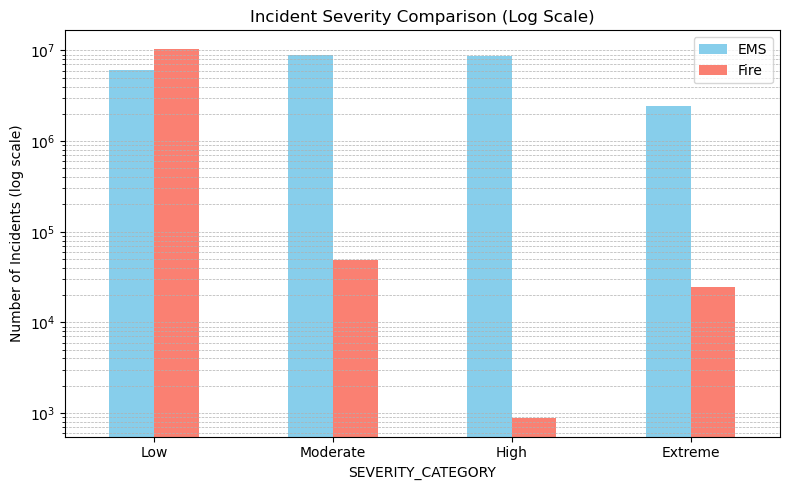

In [12]:
severity_levels = ['Low', 'Moderate', 'High', 'Extreme']
df = pd.DataFrame({
    'EMS': ems_counts.reindex(severity_levels, fill_value=0),
    'Fire': fire_counts.reindex(severity_levels, fill_value=0)
})

df.plot(kind='bar', figsize=(8, 5), color=['skyblue', 'salmon'])
plt.title('Incident Severity Comparison (Log Scale)')
plt.ylabel('Number of Incidents (log scale)')
plt.xticks(rotation=0)
plt.yscale('log')
plt.grid(axis='y', which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# Log scale needed because the low number of high level fire incidents

Unfortunately the distribution is a bit challenging, the log scale seems the most normal, but could be misleading

In [13]:
# Check the distribution of fire alarm levels
print(fire_df['HIGHEST_ALARM_LEVEL'].value_counts())

HIGHEST_ALARM_LEVEL
First Alarm              10425465
All Hands Working           45621
Seventh Alarm               24173
Second Alarm                 3035
Third Alarm                   664
Fourth Alarm                  212
Fifth Alarm or Higher         115
Fifth Alarm                   114
Complaint/Still                62
Sixth Alarm                     5
Simultaneous Call               4
Eighth Alarm                    1
Ninth Alarm or Higher           1
Name: count, dtype: int64


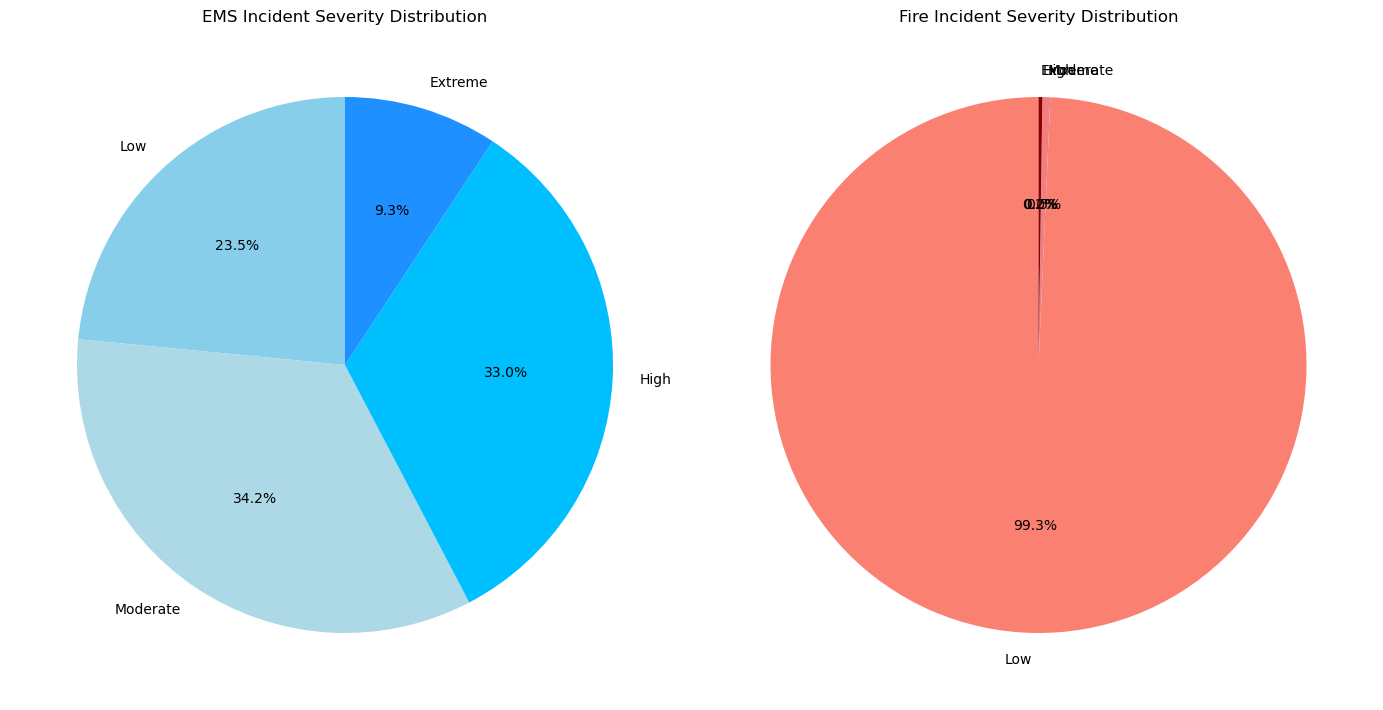

In [14]:
ems_counts = ems_df['SEVERITY_CATEGORY'].value_counts().sort_index()
fire_counts = fire_df['SEVERITY_CATEGORY'].value_counts().sort_index()

severity_levels = ['Low', 'Moderate', 'High', 'Extreme']

ems_counts = ems_counts.reindex(severity_levels, fill_value=0)
fire_counts = fire_counts.reindex(severity_levels, fill_value=0)

# Create two subplots for the pie charts
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# EMS Pie Chart
axes[0].pie(ems_counts, labels=ems_counts.index, autopct='%1.1f%%', colors=['skyblue', 'lightblue', 'deepskyblue', 'dodgerblue'], startangle=90)
axes[0].set_title('EMS Incident Severity Distribution')

# Fire Pie Chart
axes[1].pie(fire_counts, labels=fire_counts.index, autopct='%1.1f%%', colors=['salmon', 'lightcoral', 'tomato', 'darkred'], startangle=90)
axes[1].set_title('Fire Incident Severity Distribution')

plt.tight_layout()
plt.show()


To analyze the overlap between the fire and EMS data, we matched incidents that occurred within the same minute in the same zipcode, given the time-critical nature of these situations. Using a 1-minute difference, we found an 11% match from EMS to Fire and 28.6% the other way around, which we consider a reasonable result. We chose not to extend the matching timeframe to avoid the risk of false positives. However, it is possible that within a larger timeframe, additional units from the other department could have been called to an incident.

In [15]:
ems_df['INCIDENT_DATETIME'] = pd.to_datetime(ems_df['INCIDENT_DATETIME']).dt.floor('min')
fire_df['INCIDENT_DATETIME'] = pd.to_datetime(fire_df['INCIDENT_DATETIME']).dt.floor('min')

ems_subset = ems_df[['INCIDENT_DATETIME', 'BOROUGH', 'ZIPCODE']].copy()
fire_subset = fire_df[['INCIDENT_DATETIME', 'BOROUGH', 'ZIPCODE']].copy()

# Count how many overlapping incidents exist based on timestamp + ZIP
shared_cases = pd.merge(
    ems_subset,
    fire_subset,
    on=['INCIDENT_DATETIME', 'ZIPCODE'],
    how='inner'
)

num_shared = len(shared_cases)
total_ems = len(ems_subset)
total_fire = len(fire_subset)

print(f"Percentage of EMS incidents that match Fire: {num_shared / total_ems:.2%}")
print(f"Percentage of Fire incidents that match EMS: {num_shared / total_fire:.2%}")


C:\Users\Kaiusz Prime\AppData\Local\Temp\ipykernel_17268\1718419946.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fire_df['INCIDENT_DATETIME'] = pd.to_datetime(fire_df['INCIDENT_DATETIME']).dt.floor('min')


Percentage of EMS incidents that match Fire: 11.05%
Percentage of Fire incidents that match EMS: 27.60%


We don’t have the exact location of the incidents, so we used ZIP codes to place them on a map. This lets us see which ZIP code areas have the most cases.

We also split the data by borough and then by ZIP code zones. Each zone shows how many incidents happened there, and we separated fire cases into medical and non-medical ones. This makes it easier to spot which areas have more emergencies.

ZIP codes aren’t perfect for mapping real locations since they’re made for mail delivery, but they still give us a good idea of where things are happening.

We gathered a list of all NYC ZIP codes and organized them by borough. Using a CSV file that maps each ZIP code to its corresponding latitude and longitude, we added GPS coordinates to our dataframes to support geographic analysis.


In [16]:
# Remove '.0' from the ZIP codes
fire_df['ZIPCODE'] = fire_df['ZIPCODE'].str.replace('.0', '', regex=False)
ems_df['ZIPCODE'] = ems_df['ZIPCODE'].str.replace('.0', '', regex=False)

In [17]:
zipcode_df = pd.read_csv('zip_lat_long.csv')

# Define a list of NYC ZIP codes based on the csv
nyc_zip_codes = [
    # Bronx ZIP codes
    10463, 10471, 10466, 10469, 10470, 10475, 10458, 10467, 10468, 10461, 10462, 10464, 10465, 10472, 10473,
    10453, 10457, 10460, 10451, 10452, 10456, 10454, 10455, 10459, 10474,
    # Brooklyn ZIP codes
    11211, 11222, 11201, 11205, 11215, 11217, 11231, 11213, 11212, 11216, 11233, 11238,
    11207, 11208, 11220, 11232, 11204, 11218, 11219, 11230, 11203, 11210, 11225, 11226,
    11234, 11236, 11239, 11209, 11214, 11228, 11223, 11224, 11229, 11235,
    11206, 11221, 11237,
    # Manhattan ZIP codes
    10031, 10032, 10033, 10034, 10040, 10026, 10027, 10030, 10037, 10039, 10029, 10035,
    10023, 10024, 10025, 10021, 10028, 10044, 10128, 10001, 10011, 10018, 10019, 10020, 10036,
    10010, 10016, 10017, 10022, 10012, 10013, 10014, 10002, 10003, 10009, 10004, 10005, 10006, 10007, 10038, 10280,
    # Queens ZIP codes
    11101, 11102, 11103, 11104, 11105, 11106, 11368, 11369, 11370, 11372, 11373, 11377, 11378,
    11354, 11355, 11356, 11357, 11358, 11359, 11360, 11361, 11362, 11363, 11364, 11374, 11375, 11379, 11385,
    11365, 11366, 11367, 11414, 11415, 11416, 11417, 11418, 11419, 11420, 11421, 11412, 11423, 11432, 11433, 11434, 11435, 11436,
    11004, 11005, 11411, 11413, 11422, 11426, 11427, 11428, 11429, 11691, 11692, 11693, 11694, 11695, 11697,
    # Staten Island ZIP codes
    10302, 10303, 10310, 10301, 10304, 10305, 10306, 10307, 10308, 10309, 10312
]

# Filter for NYC ZIP codes only
zipcode_df_nyc = zipcode_df[zipcode_df['ZIP'].isin(nyc_zip_codes)].copy()
zipcode_df_nyc['ZIP'] = zipcode_df_nyc['ZIP'].astype(int)

fire_df['ZIPCODE'] = pd.to_numeric(fire_df['ZIPCODE'], errors='coerce')  
fire_df = fire_df.dropna(subset=['ZIPCODE'])                             
fire_df['ZIPCODE'] = fire_df['ZIPCODE'].astype(int)                      

ems_df['ZIPCODE'] = pd.to_numeric(ems_df['ZIPCODE'], errors='coerce')
ems_df = ems_df.dropna(subset=['ZIPCODE'])
ems_df['ZIPCODE'] = ems_df['ZIPCODE'].astype(int)


# Merge EMS and Fire datasets with NYC ZIP code coordinates
fire_df_gps = pd.merge(fire_df, zipcode_df_nyc, left_on='ZIPCODE', right_on='ZIP', how='left')
ems_df_gps = pd.merge(ems_df, zipcode_df_nyc, left_on='ZIPCODE', right_on='ZIP', how='left')

In [18]:
# EMS + Fire grouped summary
# Grouping fire incidents
non_medical_fire_types = [
    'NonMedical Emergencies',
    'Structural Fires',
    'NonMedical MFAs',
    'NonStructural Fires'
]
medical_fire_types = [
    'Medical Emergencies',
    'Medical MFAs'
]

# Group fire incidents by ZIP and type
fire_counts_by_zip = fire_df.groupby(['ZIPCODE', 'INCIDENT_CLASSIFICATION_GROUP']).size().unstack(fill_value=0)
fire_counts_by_zip['Fire_Medical'] = fire_counts_by_zip.get('Medical Emergencies', 0) + fire_counts_by_zip.get('Medical MFAs', 0)
fire_counts_by_zip['Fire_NonMedical'] = sum(fire_counts_by_zip.get(col, 0) for col in non_medical_fire_types)
fire_counts_by_zip_summary = fire_counts_by_zip[['Fire_Medical', 'Fire_NonMedical']].copy()

# EMS count
ems_counts_by_zip = ems_df['ZIPCODE'].value_counts().rename('EMS_Count')

# Merge into one dataframe
zip_summary = zipcode_df_nyc[['ZIP', 'LAT', 'LNG']].copy()
zip_summary = zip_summary.merge(fire_counts_by_zip_summary, left_on='ZIP', right_index=True, how='left')
zip_summary = zip_summary.merge(ems_counts_by_zip, left_on='ZIP', right_index=True, how='left')
zip_summary.fillna(0, inplace=True)
zip_summary['Total'] = zip_summary['EMS_Count'] + zip_summary['Fire_Medical'] + zip_summary['Fire_NonMedical']

zip_summary.head()

ZIP        LAT        LNG  Fire_Medical  Fire_NonMedical  EMS_Count  \
2569  10001  40.750633 -73.997177         51755            47142     282122   
2570  10002  40.715775 -73.986212         61691            71114     310264   
2571  10003  40.731829 -73.989181         54608            47676     242940   
2572  10004  40.688630 -74.018244          7463             7677      38661   
2573  10005  40.706027 -74.008835          4694             6718      20231   

       Total  
2569  381019  
2570  443069  
2571  345224  
2572   53801  
2573   31643

Given the high volume of incidents (numbering in the millions) plotting every single event as a point on the map is computationally infeasible and visually overwhelming. The available geographic data (zipcode) doesn't provide exact coordinates for each incident, which makes visualizing them as individual points even less effective.

To address these challenges, we chose to aggregate incidents at the ZIP code level. This approach not only improves performance but also aligns with the granularity of our data.

Each ZIP code area is represented by a single circle marker, where:

- Color indicates the total volume of incidents (e.g., green for low volume, red for high volume)

- Size scales with the total number of incidents in that ZIP code

We deliberately avoid marker clustering, as clusters can hide data patterns and change arbitrarily with zoom level. By assigning one marker per ZIP code, we maintain a consistent representation.


In [19]:
# Set of functions needed to create and style the map

q1 = zip_summary['Total'].quantile(0.25)
q2 = zip_summary['Total'].quantile(0.5)
q3 = zip_summary['Total'].quantile(0.75)

def get_borough_color(borough_name):
    borough_colors = {
        'Bronx': 'green',
        'Brooklyn': 'yellow',
        'Manhattan': 'coral',
        'Queens': 'skyblue',
        'Staten Island': 'red'
    }
    return borough_colors.get(borough_name, 'lightgray')

def style_boroughs(feature):
    borough_name = feature['properties']['name']
    color = get_borough_color(borough_name)
    return {
        'fillColor': color,
        'color': color,
        'weight': 3,
        'fillOpacity': 0.2,
    }

def style_zipcodes(feature):
    return {
        'fillColor': 'none',
        'color': 'black',
        'weight': 1.5,
        'fillOpacity': 0.3
    }

def create_marker(location, color, size, popup_text, cluster):
    folium.CircleMarker(
        location=location,
        radius=size,
        color='black',
        weight=1,
        fill=True,
        fill_color=color,
        fill_opacity=0.9,
        popup=popup_text
    ).add_to(cluster)

# Based on total incidents
def get_color(total):
    if total == 0:
        return 'gray'
    elif total < q1:
        return 'lightgreen'
    elif total < q2:
        return 'yellow'
    elif total < q3:
        return 'orange'
    else:
        return 'red'

# Based on total incidents
def get_size(total):
    if total == 0:
        return 4
    elif total < q1:
        return 6
    elif total < q2:
        return 8
    elif total < q3:
        return 10
    else:
        return 12



Geojson data was boroughed from the internet to highlight boroughs and zipcode areas

In [20]:
# Create the base map
map_nyc = folium.Map(location=[40.7128, -74.0060], zoom_start=10)

# Borough styling
boroughs_geojson = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/new-york-city-boroughs.geojson'

GeoJson(
    boroughs_geojson,
    name='boroughs',
    style_function=style_boroughs,
    tooltip=folium.GeoJsonTooltip(fields=['name'], aliases=['Borough:'], localize=True)
).add_to(map_nyc)


# Add ZIP Code boundaries
zipcodes_geojson = 'nyc-zip-code-tabulation-areas-polygons.geojson'  # Path to downloaded GeoJSON file from the url under
#https://github.com/fedhere/PUI2015_EC/blob/master/mam1612_EC/nyc-zip-code-tabulation-areas-polygons.geojson

folium.GeoJson(
    zipcodes_geojson,
    name='ZIP Code Boundaries',
    style_function=style_zipcodes,
    tooltip=folium.GeoJsonTooltip(fields=['postalCode'], aliases=['ZIP Code:'], localize=True)
).add_to(map_nyc)


zip_marker = MarkerCluster(name="ZIP Codes").add_to(map_nyc)
ems_fire = map_nyc 

# Count EMS and Fire incidents per ZIP
ems_counts = ems_df_gps['ZIP'].value_counts().to_dict()
fire_counts = fire_df_gps['ZIP'].value_counts().to_dict()


# Add summary circle markers per ZIP with detailed popup info
for _, row in zip_summary.iterrows():
    lat, lng = row['LAT'], row['LNG']
    if pd.notnull(lat) and pd.notnull(lng):
        total = int(row['Total'])
        ems = int(row['EMS_Count'])
        fire_medical = int(row['Fire_Medical'])
        fire_nonmedical = int(row['Fire_NonMedical'])

        popup_html = (
            f"<b>ZIP:</b> {int(row['ZIP'])}<br>"
            f"<b>Total Incidents:</b> {total}<br>"
            f"<b>EMS:</b> {ems}<br>"
            f"<b>Fire (Medical):</b> {fire_medical}<br>"
            f"<b>Fire (Non-Medical):</b> {fire_nonmedical}"
        )
        popup = folium.Popup(popup_html, max_width=300)

        create_marker(
            location=[lat, lng],
            color=get_color(total),
            size=get_size(total),
            popup_text=popup,
            cluster=ems_fire
        )


map_nyc
# https://www.nyc.gov/assets/doh/downloads/pdf/ah/zipcodetable.pdf # zipcodes

In [21]:
map_nyc.save("nyc_incidents_zip_map.html")


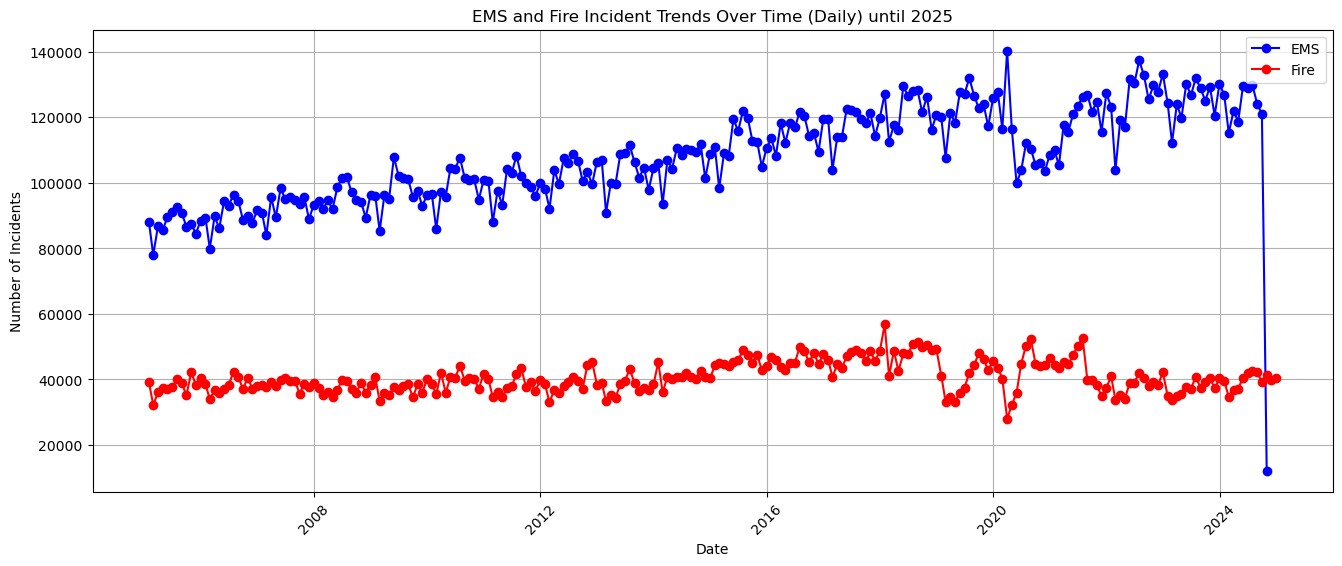

In [22]:
end_date = '2024-12-31'

ems_per_month = ems_df[ems_df['INCIDENT_DATETIME'] <= end_date].resample("M", on="INCIDENT_DATETIME").size()
fire_per_month = fire_df[fire_df['INCIDENT_DATETIME'] <= end_date].resample("M", on="INCIDENT_DATETIME").size()

plt.figure(figsize=(16, 6))

plt.plot(ems_per_month.index, ems_per_month.values, marker="o", linestyle="-", color="blue", label="EMS")
plt.plot(fire_per_month.index, fire_per_month.values, marker="o", linestyle="-", color="red", label="Fire")

plt.xlabel("Date")
plt.ylabel("Number of Incidents")
plt.title("EMS and Fire Incident Trends Over Time (Daily) until 2025")
plt.xticks(rotation=45)
plt.grid(True)

plt.legend()
plt.show()


Interactive plot section

We created a series of barplots based on the boroughs. We want to showcase the response time of each incident type baesd on zipcode areas. This way it is possible to contrast the number of incidents with response times, maybe finding out if an area is understaffed.

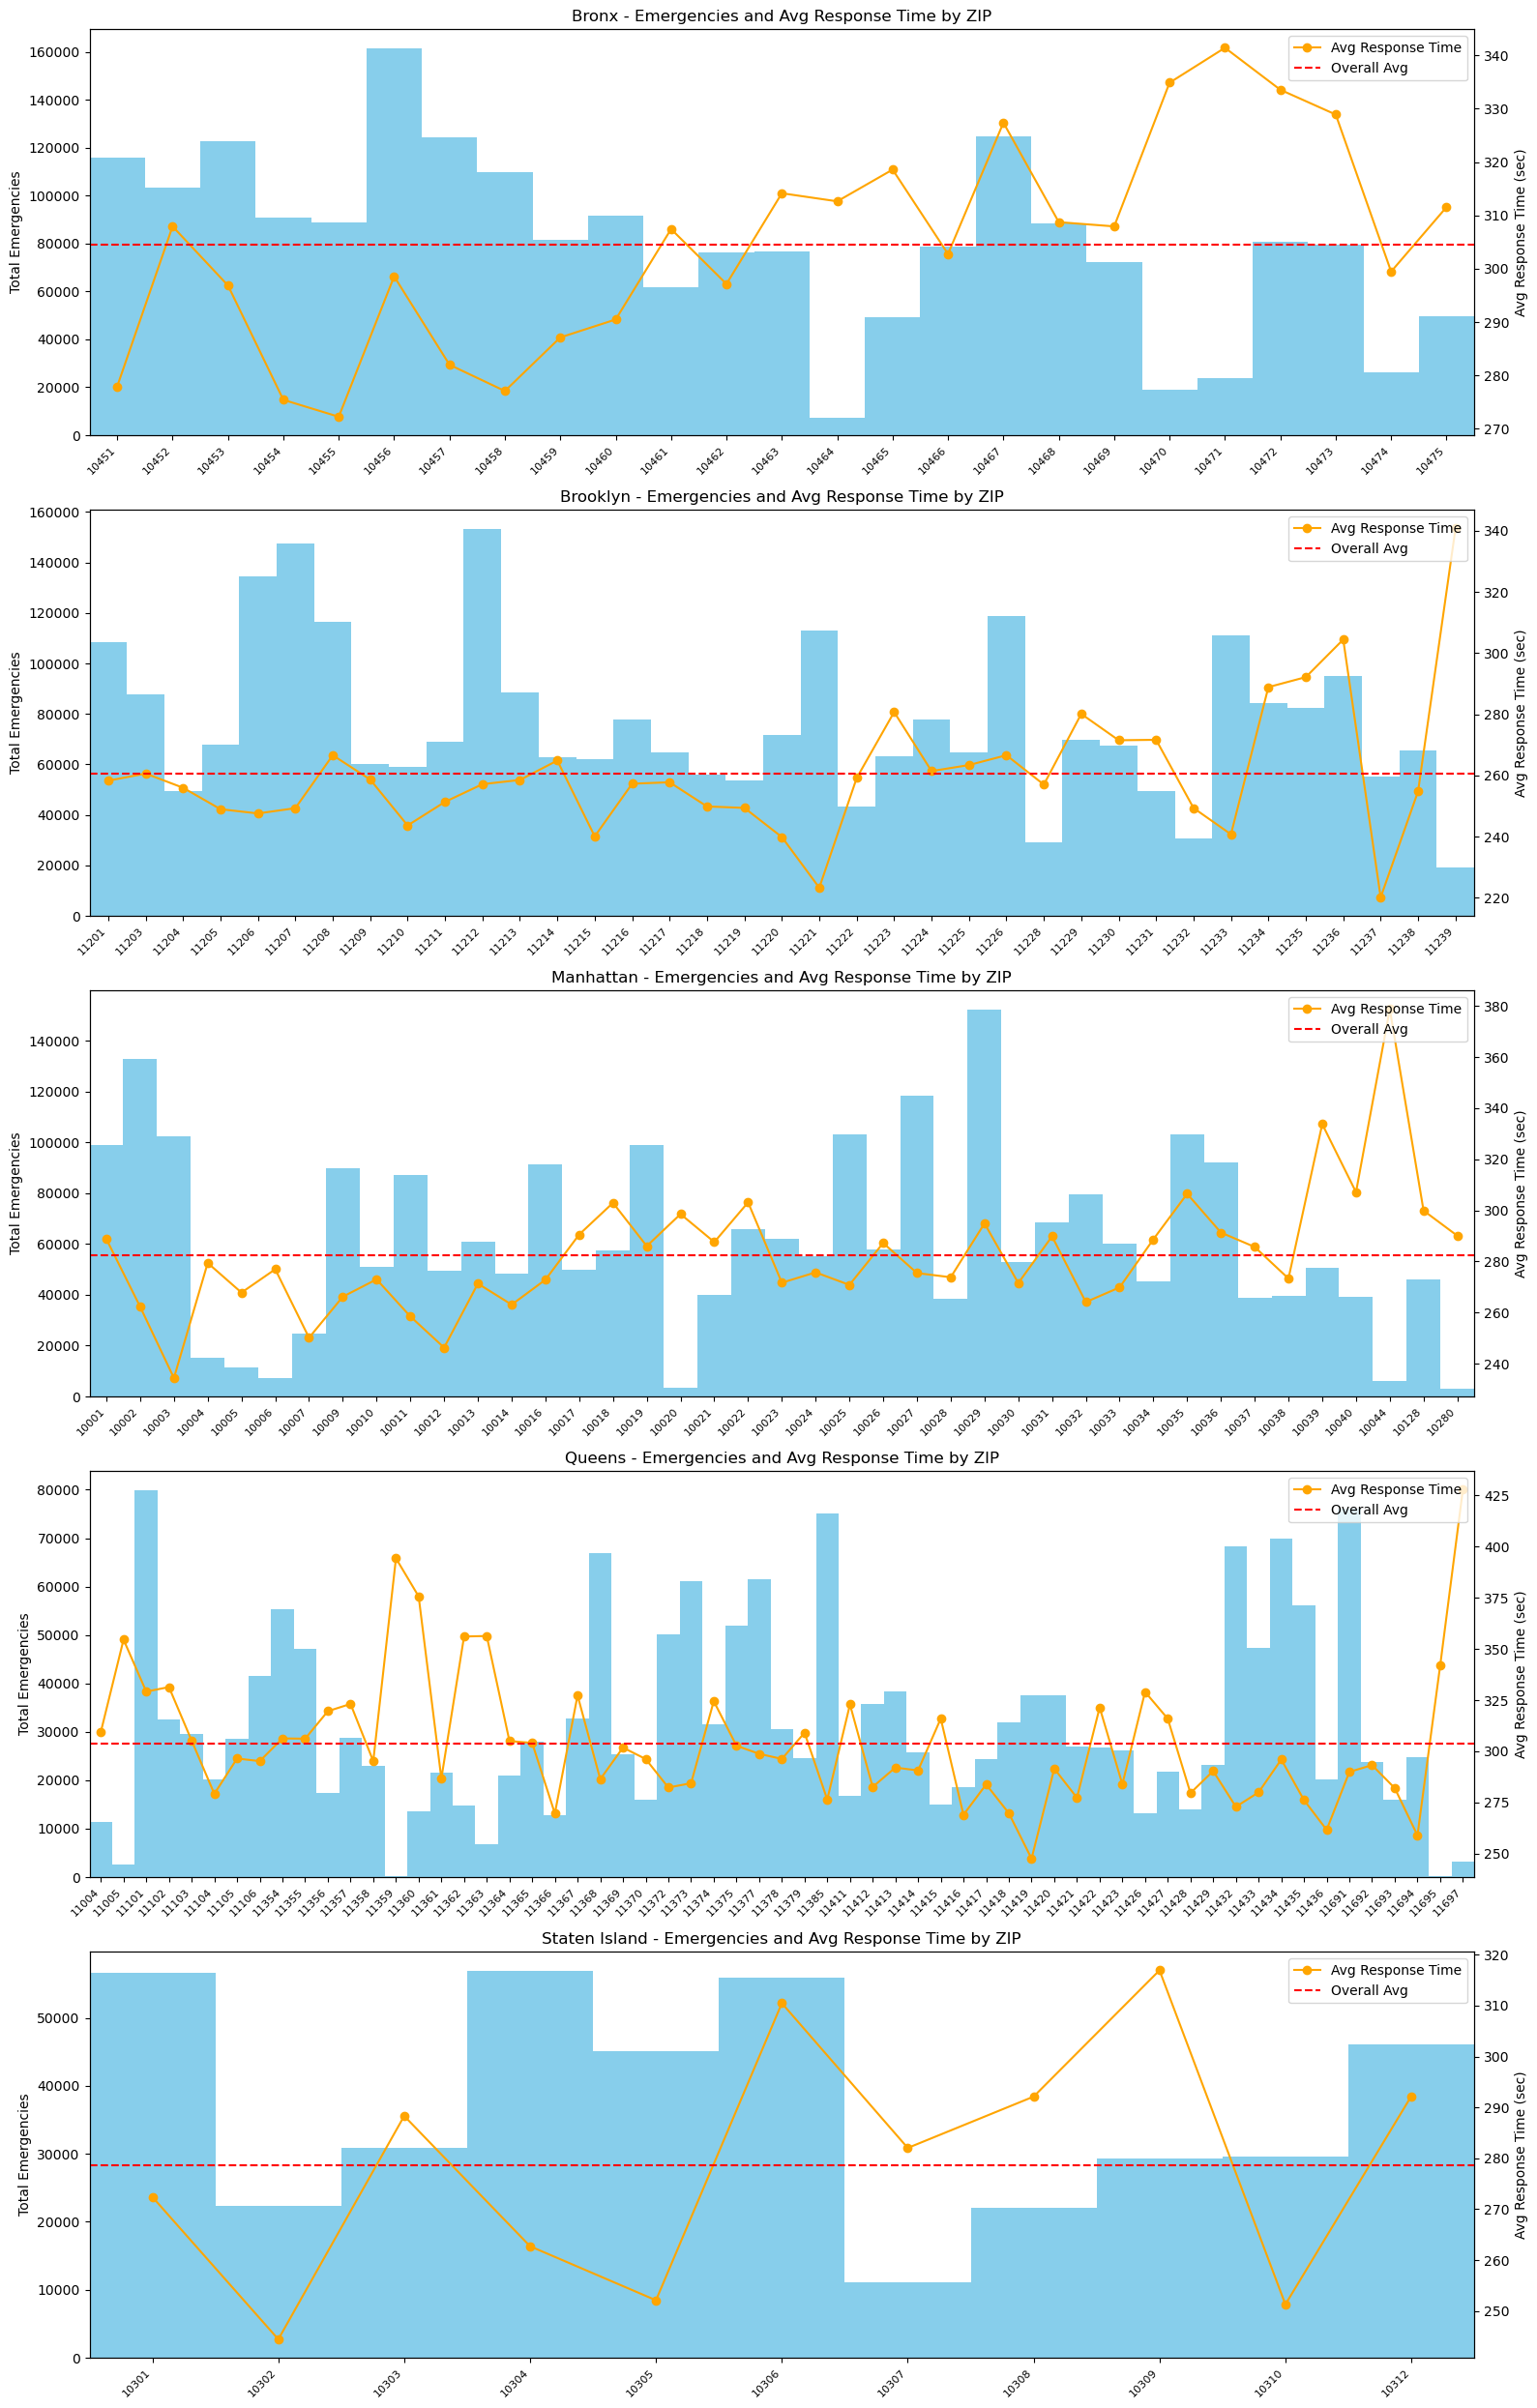

In [23]:
# ZIP code groups
boroughs = {
    "Bronx": [10463, 10471, 10466, 10469, 10470, 10475, 10458, 10467, 10468, 10461, 10462, 10464, 10465, 10472, 10473,
              10453, 10457, 10460, 10451, 10452, 10456, 10454, 10455, 10459, 10474],
    "Brooklyn": [11211, 11222, 11201, 11205, 11215, 11217, 11231, 11213, 11212, 11216, 11233, 11238, 11207, 11208, 11220,
                 11232, 11204, 11218, 11219, 11230, 11203, 11210, 11225, 11226, 11234, 11236, 11239, 11209, 11214, 11228,
                 11223, 11224, 11229, 11235, 11206, 11221, 11237],
    "Manhattan": [10031, 10032, 10033, 10034, 10040, 10026, 10027, 10030, 10037, 10039, 10029, 10035, 10023, 10024, 10025,
                  10021, 10028, 10044, 10128, 10001, 10011, 10018, 10019, 10020, 10036, 10010, 10016, 10017, 10022, 10012,
                  10013, 10014, 10002, 10003, 10009, 10004, 10005, 10006, 10007, 10038, 10280],
    "Queens": [11101, 11102, 11103, 11104, 11105, 11106, 11368, 11369, 11370, 11372, 11373, 11377, 11378, 11354, 11355,
               11356, 11357, 11358, 11359, 11360, 11361, 11362, 11363, 11364, 11374, 11375, 11379, 11385, 11365, 11366,
               11367, 11414, 11415, 11416, 11417, 11418, 11419, 11420, 11421, 11412, 11423, 11432, 11433, 11434, 11435,
               11436, 11004, 11005, 11411, 11413, 11422, 11426, 11427, 11428, 11429, 11691, 11692, 11693, 11694, 11695, 11697],
    "Staten Island": [10302, 10303, 10310, 10301, 10304, 10305, 10306, 10307, 10308, 10309, 10312]
}

response_time_stats = fire_df_gps.groupby('ZIPCODE').agg(
    avg_response_time=('INCIDENT_RESPONSE_SECONDS_QY', 'mean'),
    total_incidents=('INCIDENT_RESPONSE_SECONDS_QY', 'count')
).reset_index()

response_time_stats = response_time_stats.iloc[:-1]
response_time_stats['ZIPCODE'] = response_time_stats['ZIPCODE'].astype(str)

# subplots
n_boroughs = len(boroughs)
fig, axes = plt.subplots(n_boroughs, 1, figsize=(16, 5 * n_boroughs))
if n_boroughs == 1:
    axes = [axes] 

# Plot each borough
for ax_idx, (borough, zip_list) in enumerate(boroughs.items()):
    ax1 = axes[ax_idx]
    zip_list_str = list(map(str, zip_list))
    data = response_time_stats[response_time_stats['ZIPCODE'].isin(zip_list_str)]

    x = range(len(data))

    ax1.bar(x, data['total_incidents'], color='skyblue', width=1.0, align='center')
    ax1.set_xlim(-0.5, len(data) - 0.5)
    ax1.set_ylabel('Total Emergencies', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    ax1.set_xticks(x)
    ax1.set_xticklabels(data['ZIPCODE'], rotation=45, ha='right', fontsize=8)

    ax2 = ax1.twinx()
    ax2.plot(x, data['avg_response_time'], color='orange', marker='o', label='Avg Response Time')
    ax2.set_ylabel('Avg Response Time (sec)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    overall_avg = data['avg_response_time'].mean()
    ax2.axhline(y=overall_avg, color='red', linestyle='--', linewidth=1.5, label='Overall Avg')
    ax2.legend(loc='upper right')

    ax1.set_title(f'{borough} - Emergencies and Avg Response Time by ZIP')

plt.tight_layout()
plt.show()


Same concept but using police precincts as a geographical group (EMS)

In [40]:
from bokeh.io import output_notebook, show, reset_output
from bokeh.layouts import column, row
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import Select, MultiSelect, HoverTool, CustomJS, Range1d, LinearAxis, Legend, LegendItem

output_notebook()

boroughs = {
    "Manhattan": [
        1, 5, 6, 7, 9, 10, 13, 14, 17, 18, 19, 20, 22, 23, 24, 25, 26, 28, 30, 32, 33, 34
    ],
    "Brooklyn": [
        60, 61, 62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 81, 83, 84, 88, 90, 94
    ],
    "Queens": [
        100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115
    ],
    "Bronx": [
        40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52
    ],
    "Staten Island": [
        120, 121, 122, 123
    ]
}

# Police Precincts GeoJSON file
precincts_gdf = gpd.read_file('nyc-police-precincts.geojson')

Loading BokehJS ...

In [ ]:
ems_gdf = gpd.GeoDataFrame(ems_df_gps, 
                           geometry=gpd.points_from_xy(ems_df_gps.LNG, ems_df_gps.LAT))

# Assign each EMS incident to the corresponding police precinct.
ems_with_precincts = gpd.sjoin(ems_gdf, precincts_gdf, how="left", predicate='within')


response_time_stats = ems_with_precincts.groupby('precinct').agg(
    avg_response_time=('INCIDENT_RESPONSE_SECONDS_QY', 'mean'),
    total_incidents=('INCIDENT_RESPONSE_SECONDS_QY', 'count')
).reset_index()

response_time_stats['precinct'] = response_time_stats['precinct'].astype(str)

# Initial Borough Setup
initial_borough = "Bronx"
initial_precincts = list(map(str, boroughs[initial_borough]))
initial_data = response_time_stats[response_time_stats['precinct'].isin(initial_precincts)]
source = ColumnDataSource(initial_data)

p = figure(x_range=list(initial_data['precinct']), height=500, width=800,
           title=f"{initial_borough} - Emergencies and Avg Response Time by Precinct")

# Left y-axis: Total Emergencies
p.vbar(x='precinct', top='total_incidents', width=0.9, source=source,
       color='skyblue', legend_label="Total Emergencies")

# Y-axis range for average response time
p.extra_y_ranges = {"response_time": Range1d(start=0, end=response_time_stats['avg_response_time'].max() * 1.2)}
p.add_layout(LinearAxis(y_range_name="response_time", axis_label="Avg Response Time (sec)"), 'right')

# Right y-axis: Avg Response Time
p.line(x='precinct', y='avg_response_time', source=source, y_range_name="response_time",
       color='orange', line_width=2, legend_label="Avg Response Time")
p.scatter(x='precinct', y='avg_response_time', source=source, y_range_name="response_time",
          size=8, color='orange')

# Tooltip
p.add_tools(HoverTool(tooltips=[
    ("Precinct", "@precinct"),
    ("Incidents", "@total_incidents"),
    ("Avg Response Time", "@avg_response_time")
]))

# Styling
p.xaxis.major_label_orientation = 1
p.yaxis.axis_label = "Total Emergencies"
p.legend.location = "top_right"

# Widgets
borough_select = Select(title="Select Borough:", value=initial_borough, options=list(boroughs.keys()))
precinct_select = MultiSelect(title="Select Precinct(s):", value=initial_precincts, options=initial_precincts)

# JS Callback to update plot based on precincts selected
callback = CustomJS(args=dict(
    source=source,
    all_data=response_time_stats.to_dict('list'),
    borough_select=borough_select,
    precinct_select=precinct_select,
    p=p
), code="""
    const selected_precincts = precinct_select.value;
    const borough = borough_select.value;

    const all = all_data;
    const data = {
        precinct: [],
        avg_response_time: [],
        total_incidents: []
    };

    for (let i = 0; i < all['precinct'].length; i++) {
        const prec = all['precinct'][i];
        if (selected_precincts.includes(prec)) {
            data.precinct.push(prec);
            data.avg_response_time.push(all['avg_response_time'][i]);
            data.total_incidents.push(all['total_incidents'][i]);
        }
    }

    source.data = data;
    p.x_range.factors = data.precinct;
    p.title.text = borough + " - Emergencies and Avg Response Time by Precinct";
    source.change.emit();
""")

# Update precinct list when borough changes
borough_select.js_on_change('value', CustomJS(args=dict(
    boroughs=boroughs,
    borough_select=borough_select,
    precinct_select=precinct_select
), code="""
    const borough = borough_select.value;
    const precincts = boroughs[borough].map(p => p.toString());
    precinct_select.options = precincts;
    precinct_select.value = precincts;
    precinct_select.change.emit();  // Trigger callback
"""))

precinct_select.js_on_change('value', callback)
layout = row(column(borough_select, precinct_select), p)

output_file("ems_precincts.html")
reset_output()
output_notebook()
show(layout)


In [45]:
# Now for Fire incidents
fire_gdf = gpd.GeoDataFrame(fire_df_gps, 
                           geometry=gpd.points_from_xy(fire_df_gps.LNG, fire_df_gps.LAT))

# Assign each Fire incident to the corresponding police precinct.
fire_with_precincts = gpd.sjoin(fire_gdf, precincts_gdf, how="left", predicate='within')

response_time_stats = fire_with_precincts.groupby('precinct').agg(
    avg_response_time=('INCIDENT_RESPONSE_SECONDS_QY', 'mean'),
    total_incidents=('INCIDENT_RESPONSE_SECONDS_QY', 'count')
).reset_index()

response_time_stats['precinct'] = response_time_stats['precinct'].astype(str)

initial_borough = "Bronx"
initial_precincts = list(map(str, boroughs[initial_borough]))
initial_data = response_time_stats[response_time_stats['precinct'].isin(initial_precincts)]
source = ColumnDataSource(initial_data)


p = figure(x_range=list(initial_data['precinct']), height=500, width=800,
           title=f"{initial_borough} - Emergencies and Avg Response Time by Precinct")

p.vbar(x='precinct', top='total_incidents', width=0.9, source=source,
       color='red', legend_label="Total Emergencies")

p.extra_y_ranges = {"response_time": Range1d(start=0, end=response_time_stats['avg_response_time'].max() * 1.2)}
p.add_layout(LinearAxis(y_range_name="response_time", axis_label="Avg Response Time (sec)"), 'right')

p.line(x='precinct', y='avg_response_time', source=source, y_range_name="response_time",
       color='orange', line_width=2, legend_label="Avg Response Time")
p.scatter(x='precinct', y='avg_response_time', source=source, y_range_name="response_time",
          size=8, color='orange')

p.add_tools(HoverTool(tooltips=[
    ("Precinct", "@precinct"),
    ("Incidents", "@total_incidents"),
    ("Avg Response Time", "@avg_response_time")
]))

p.xaxis.major_label_orientation = 1
p.yaxis.axis_label = "Total Emergencies"
p.legend.location = "top_right"

borough_select = Select(title="Select Borough:", value=initial_borough, options=list(boroughs.keys()))
precinct_select = MultiSelect(title="Select Precinct(s):", value=initial_precincts, options=initial_precincts)

callback = CustomJS(args=dict(
    source=source,
    all_data=response_time_stats.to_dict('list'),
    borough_select=borough_select,
    precinct_select=precinct_select,
    p=p
), code="""
    const selected_precincts = precinct_select.value;
    const borough = borough_select.value;

    const all = all_data;
    const data = {
        precinct: [],
        avg_response_time: [],
        total_incidents: []
    };

    for (let i = 0; i < all['precinct'].length; i++) {
        const prec = all['precinct'][i];
        if (selected_precincts.includes(prec)) {
            data.precinct.push(prec);
            data.avg_response_time.push(all['avg_response_time'][i]);
            data.total_incidents.push(all['total_incidents'][i]);
        }
    }

    source.data = data;
    p.x_range.factors = data.precinct;
    p.title.text = borough + " - Emergencies and Avg Response Time by Precinct";
    source.change.emit();
""")

borough_select.js_on_change('value', CustomJS(args=dict(
    boroughs=boroughs,
    borough_select=borough_select,
    precinct_select=precinct_select
), code="""
    const borough = borough_select.value;
    const precincts = boroughs[borough].map(p => p.toString());
    precinct_select.options = precincts;
    precinct_select.value = precincts;
    precinct_select.change.emit();  // Trigger callback
"""))

precinct_select.js_on_change('value', callback)

layout = row(column(borough_select, precinct_select), p)
output_file("fire_precincts.html")
reset_output()
output_notebook()
show(layout)

C:\Users\Kaiusz Prime\AppData\Local\Temp\ipykernel_17268\1234922831.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  fire_with_precincts = gpd.sjoin(fire_gdf, precincts_gdf, how="left", predicate='within')


Loading BokehJS ...

In order to analyze EMS incident types we map the codes found in the dataset to their explanation (found online) 

In [30]:
# Full dictionary combining common EMS call types and MCIxx codes

call_type_mapping = {
    "INJURY": "General Injury",
    "OTHER": "Other",
    "EDP": "Emotionally Disturbed Person",
    "STATEP": "State Psychiatric Emergency",
    "UNC": "Unconscious",
    "SEIZR": "Seizure",
    "RAPE": "Sexual Assault",
    "DIFFBR": "Difficulty Breathing",
    "CHILDA": "Child Abuse",
    "PD13": "Police Assist",
    "MVAINJ": "Motor Vehicle Accident with Injury",
    "MVA": "Motor Vehicle Accident",
    "INJMIN": "Minor Injury",
    "INJMAJ": "Major Injury",
    "CARD": "Cardiac Issue",
    "SICK": "Sick (General)",
    "ASTHMA": "Asthma Attack",
    "PEDSTR": "Pedestrian Struck",
    "ARREST": "Cardiac Arrest",
    "FIRE75": "Fire-Related Incident",
    "FIRE77": "Fire-Related Incident",
    "SHOT": "Gunshot Wound",
    "STNDBY": "Standby Medical",
    "STAB": "Stabbing",
    "INHALE": "Smoke Inhalation / Gas Exposure",
    "DRUG": "Drug Overdose",
    "TRAUMA": "Major Trauma",
    "ABDPN": "Abdominal Pain",
    "RESPIR": "Respiratory Emergency",
    "CVA": "Cerebrovascular Accident (Stroke)",
    "SICPED": "Sick Child",
    "JUMPUP": "Jumped from Height (Suicide)",
    "BURNMI": "Minor Burns",
    "DROWN": "Drowning",
    "BURNMA": "Major Burns",
    "OBLAB": "Labor / Childbirth",
    "CVAC": "Cardiovascular Arrest",
    "ANAPH": "Anaphylaxis",
    "ALTMEN": "Altered Mental Status",
    "HYPTN": "Hypertension",
    "OBCOMP": "Obstetrics Complication",
    "UNKNOW": "Unknown Emergency",
    "CHOKE": "Choking",
    "SICMIN": "Sick Minor",
    "INBLED": "Internal Bleeding",
    "ASTHMB": "Asthma (Severe)",
    "OBMIS": "Obstetrics Miscarriage",
    "MCI21P": "Mass Casualty Incident - Building Fire",
    "SPEVNT": "Special Event Medical Standby",
    "GYNHEM": "Gynecological Emergency",
    "SICKFC": "Sick (Full Code)",
    "HEAT": "Heat Stroke / Heat Exhaustion",
    "MEDVAC": "Medical Evacuation",
    "PEDFC": "Pedestrian (Full Code)",
    "DOA": "Dead on Arrival",
    "VENOM": "Animal Bite / Venom Exposure",
    "MEDRXN": "Medication Reaction",
    "AMPMIN": "Minor Accident / Injury",
    "JUMPDN": "Jumped Down",
    "COLD": "Hypothermia / Cold Exposure",
    "OBMAJ": "Major Obstetric Emergency",
    "INJALS": "Advanced Life Support Injury",
    "MCI21": "Mass Casualty Incident - Building Fire",
    "CARDBR": "Cardiac with Breathing Problem",
    "RESPFC": "Respiratory Failure",
    "ASTHFC": "Severe Asthma",
    "SAFE": "Safety Standby",
    "EDPC": "Emergency Department - Patient Care",
    "MCI59": "General Mass Casualty",
    "COVINF": "COVID-19 Infection",
    "CDBRFC": "Cardiac with Breathing Problem (Full Code)",
    "DIFFFC": "Severe Difficulty Breathing",
    "SICMFC": "Sick Minor (Full Code)",
    "ALTMFC": "Altered Mental Status (Full Code)",
    "PD13C": "Police Assist (Code)",
    "T-DFBR": "Traffic Accident with Breathing Difficulty",
    "T-INJ": "Trauma Injury",
    "T-SICK": "Sick Person (Trauma)",
    "T-ABDP": "Abdominal Pain (Trauma)",
    "CARDFC": "Cardiac Emergency (Full Code)",
    "UNCFC": "Unconscious (Full Code)",
    "DRUGFC": "Drug Overdose (Full Code)",
    "STNDBM": "Standby Medical",
    "ABDPFC": "Abdominal Pain (Full Code)",
    "EDPM": "Emergency Department Patient Movement",
    "T-EDP": "Emotionally Disturbed Person (Trauma)",
    "ACTIVE": "Active Emergency",
    "T-UNKN": "Unknown Emergency (Trauma)",
    "MEDRFC": "Medication Reaction (Full Code)",
    "T-ARST": "Trauma Cardiac Arrest",
    "T-SHOT": "Trauma Gunshot Wound",
    "T-UNC": "Trauma Unconscious",
    "UNCRF": "Unknown (Refused Care)",
    "EDPT": "Emergency Department Patient Transport",
    "MCI77": "Mass Casualty Event - Hospital Surge",
    "EDPE": "Emergency Department - Emergency",
    "BURNHZ": "Hazardous Burn Incident",
    "T-TEXT": "Text Messaging Emergency",
    "ASTHMC": "Severe Asthma (Critical)",
    "MCI43": "Mass Casualty Event - Public Event",
    "OBOUT": "Obstetric Emergency - Outside",
    "MCI22P": "Mass Casualty Incident - Transit (Subway)",
    "ELECT": "Electrocution",
    "GYNMAJ": "Gynecological Emergency (Major)",
    "SICKRF": "Sick Person (Respiratory Failure)",
    "MCI29P": "Mass Casualty Incident - Chemical Exposure",
    "MCI59P": "Mass Casualty Incident (Preset)",
    "MCI26P": "Mass Casualty Incident - School Bus",
    "STRANS": "Transport of Sick Patient",
    "MCI24P": "Mass Casualty Incident - Active Shooter",
    "MCI48P": "Mass Casualty Incident - Radiation Exposure",
    "MCI29": "Chemical/Biological Exposure",
    "MCI32P": "Mass Casualty Incident - Utility Failure",
    "PEDRF": "Pedestrian Injury (Respiratory Failure)",
    "MCI43P": "Mass Casualty Event - Special Event",
    "MCI27P": "Mass Casualty Incident - Hazardous Material",
    "MCI35P": "Mass Casualty Incident - Terrorist Threat",
    "DIFFRF": "Difficulty Breathing (Respiratory Failure)",
    "MCI23P": "Mass Casualty Incident - Building Collapse",
    "AMPMAJ": "Major Ambulance Response",
    "MCI44P": "Cold Weather Shelter Emergency",
    "MCI31P": "Mass Casualty Incident - Train Derailment",
    "MCI33P": "Mass Casualty Incident - Explosion",
    "MCI30P": "Mass Casualty Incident - Highway",
    "MCI34P": "Mass Casualty Incident - Civil Disturbance",
    "MCI58P": "Pandemic Emergency",
    "MCI40P": "Mass Casualty Incident - Bridge Collapse",
    "MCI38P": "Mass Casualty Incident - Flooding",
    "MCI80P": "COVID-19 Surge Protocol",
    "MCI80": "COVID-19 Pandemic Emergency",
    "MCI77": "Hospital Surge",
    "MCI33": "Explosion",
    "MCI31": "Train Derailment",
    "MCI32": "Utility Outage with Medical Need",
    "MCI42P": "High-Rise Evacuation",
    "MCI25P": "High-Rise Fire",
    "MCI28P": "Mass Casualty Incident - Radiation Exposure",
    "CARDFT": "Cardiac Failure (Transport)",
    "ASTHFT": "Asthma Attack (Transport)",
    "UNCFT": "Unconscious (Transport)",
    "DRUGFT": "Drug Overdose (Transport)",
    "T-INBL": "Trauma - Internal Bleeding",
    "ABDPRF": "Abdominal Pain (Respiratory Failure)",
    "T-ACTV": "Trauma - Active Emergency",
    "PEDFT": "Pediatric Emergency (Transport)",
    "ANAPFT": "Anaphylaxis (Transport)",
    "T-CARD": "Trauma - Cardiac Event",
    "T-STAB": "Trauma - Stabbing",
    "ANAPFC": "Anaphylaxis (Full Code)",
    "T-TRMA": "Trauma - General",
    "CVAFC": "Cerebrovascular Accident (Full Code)",
    "ALMNFC": "Altered Mental Status (Full Code)",
    "ARREFC": "Cardiac Arrest (Full Code)",
    "MCI76": "Mass Casualty Incident - Civil Unrest",
    "RESPFT": "Respiratory Failure (Transport)",
    "MVAINS": "Motor Vehicle Accident - Injury (Severe)",
    "STATFT": "Stroke Alert (Transport)",
    "T-MVAI": "Trauma - Motor Vehicle Accident Injury",
    "MCI26": "Mass Casualty Incident - School Bus Accident",
    "T-CVAC": "Trauma - Cardiovascular Arrest",
    "SEIZFC": "Seizure (Full Code)",
    "INBLFT": "Internal Bleeding (Transport)",
    "ALTMRF": "Altered Mental Status (Respiratory Failure)",
    "BURNHM": "Burns - Hazardous Materials",
    "SICKFT": "Sick Person (Transport)",
    "SICMFT": "Sick Minor (Transport)",
    "RESPRF": "Respiratory Distress (Respiratory Failure)",
    "T-ASTH": "Trauma - Asthma Attack",
    "MEDRRF": "Medication Reaction (Respiratory Failure)",
    "MCI44": "Mass Casualty Incident - Cold Weather Emergency",
    "MCI38": "Mass Casualty Incident - Flooding",
    "DOAU": "Dead on Arrival - Unknown",
    "CHOKFC": "Choking (Full Code)",
    "INBLRF": "Internal Bleeding (Respiratory Failure)",
    "SICMRF": "Sick Minor (Respiratory Failure)",
    "STATR": "Stroke Alert (Respiratory Failure)",
    "T-STEP": "Trauma - Fall from Elevation",
    "ASTHRF": "Asthma Attack (Respiratory Failure)",
    "T-CDBR": "Trauma - Cardiac with Breathing Difficulty",
    "MVAINM": "Motor Vehicle Accident - Injury (Minor)",
    "CVACFT": "Cardiovascular Arrest (Transport)",
    "ALTMFT": "Altered Mental Status (Transport)",
    "ARREFT": "Cardiac Arrest (Transport)",
    "CVARF": "Cardiovascular Arrest (Respiratory Failure)",
    "CARDRF": "Cardiac Emergency (Respiratory Failure)",
    "CDBRRF": "Cardiac with Breathing Difficulty (Respiratory Failure)",
    "MCI28": "Mass Casualty Incident - Radiation Exposure",
    "T-OTHR": "Trauma - Other",
    "MCI25": "Mass Casualty Incident - High-Rise Fire",
    "MCI27": "Mass Casualty Incident - Hazardous Materials",
    "DRUGRF": "Drug Overdose (Respiratory Failure)",
    "CVACRF": "Cardiovascular Arrest (Respiratory Failure)",
    "STATFC": "Stroke Alert (Full Code)",
    "T-ALTM": "Trauma - Altered Mental Status",
    "ABDPFT": "Abdominal Pain (Transport)",
    "CHOKRF": "Choking (Respiratory Failure)",
    "EVAC": "Evacuation",
    "CVACFC": "Cardiovascular Arrest (Full Code)",
    "MCI22": "Mass Casualty Incident - Transit (Subway)",
    "ABDFC": "Abdominal Pain (Full Code)",
    "T-OBST": "Trauma - Obstetric Emergency",
    "DIFFFT": "Difficulty Breathing (Transport)",
    "SEIZFT": "Seizure (Transport)",
    "ANAPRF": "Anaphylaxis (Respiratory Failure)",
    "INBLFC": "Internal Bleeding (Full Code)",
    "ARSTFC": "Cardiac Arrest (Full Code)",
    "SEIZRF": "Seizure (Respiratory Failure)",
    "MCI42": "Mass Casualty Incident - High-Rise Evacuation",
    "EDPW": "Emergency Department - Waiting",
    "PEDSTS": "Pediatric Status",
    "MCI23": "Mass Casualty Incident - Building Collapse",
    "MCI24": "Mass Casualty Incident - Active Shooter",
    "CDBRFT": "Cardiac with Breathing Difficulty (Transport)",
    "MCI40": "Mass Casualty Incident - Bridge Collapse",
    "MCI35": "Mass Casualty Incident - Terrorist Threat",
    "MCI50P": "Mass Casualty Incident - Pandemic Protocol",
    "TRAUMS": "Trauma - Severe",
    "MCI34": "Mass Casualty Incident - Civil Disturbance",
    "ARRERF": "Cardiac Arrest (Respiratory Failure)",
    "MCI50": "Mass Casualty Incident - Pandemic",
    "STATRF": "Stroke Alert (Respiratory Failure)"
    
}

call_type_df = pd.DataFrame(list(call_type_mapping.items()), columns=["Code", "Description"])

Create an interactive plot showcasing incident types per borough and police precinct

In [44]:
# Create precinct → borough and borough → color maps
precinct_to_borough = {str(p): b for b, precincts in boroughs.items() for p in precincts}
borough_colors = {
    "Bronx": "#9b59b6",
    "Brooklyn": "#3498db",
    "Manhattan": "#e67e22",
    "Queens": "#2ecc71",
    "Staten Island": "#e74c3c"
}

# Group EMS data
injury_counts = ems_with_precincts.groupby(['FINAL_CALL_TYPE', 'precinct']).size().reset_index(name='count')
injury_counts['precinct'] = injury_counts['precinct'].astype(str)

injury_counts['BOROUGH'] = injury_counts['precinct'].map(precinct_to_borough)
injury_counts['color'] = injury_counts['BOROUGH'].map(borough_colors)
injury_counts['Description'] = injury_counts['FINAL_CALL_TYPE'].map(call_type_mapping)

initial_injury = injury_counts['FINAL_CALL_TYPE'].iloc[0]
filtered = injury_counts[injury_counts['FINAL_CALL_TYPE'] == initial_injury]
source = ColumnDataSource(filtered)

p = figure(x_range=list(filtered['precinct']), height=500, width=800,
            title=f"{call_type_mapping.get(initial_injury, initial_injury)} - Emergency Count by Police Precinct",
           toolbar_location=None)

p.vbar(x='precinct', top='count', width=0.9, source=source, color='color')

p.add_tools(HoverTool(tooltips=[
    ("Precinct", "@precinct"),
    ("Borough", "@BOROUGH"),
    ("Call Type", "@Description"),  
    ("Count", "@count")
]))

p.xaxis.axis_label = "Police Precinct"
p.yaxis.axis_label = "Number of Emergencies"
p.xaxis.major_label_orientation = 1

legend_items = []
for borough, color in borough_colors.items():
    r = p.vbar(x=[" "], top=[0], width=0.0001, color=color) 
    legend_items.append(LegendItem(label=borough, renderers=[r]))

legend = Legend(items=legend_items, location="top_left", title="Borough Colors")
p.add_layout(legend, 'right')

injury_select = Select(title="Select Injury Type (FINAL_CALL_TYPE):", 
                       value=call_type_mapping[initial_injury],
                       options=sorted(injury_counts['Description'].unique().tolist()))

callback = CustomJS(args=dict(
    source=source,
    all_data=injury_counts.to_dict('list'),
    p=p,
    injury_select=injury_select
), code="""
    const selected = injury_select.value;
    const all = all_data;

    const data = {
        FINAL_CALL_TYPE: [],
        precinct: [],
        count: [],
        BOROUGH: [],
        color: [],
        Description: []
    };

    for (let i = 0; i < all['FINAL_CALL_TYPE'].length; i++) {
        if (all['Description'][i] === selected) {
            data['FINAL_CALL_TYPE'].push(all['FINAL_CALL_TYPE'][i]);
            data['precinct'].push(all['precinct'][i]);
            data['count'].push(all['count'][i]);
            data['BOROUGH'].push(all['BOROUGH'][i]);
            data['color'].push(all['color'][i]);
            data['Description'].push(all['Description'][i]);
        }
    }

    source.data = data;
    p.x_range.factors = data['precinct'];
    p.title.text = selected + " - Emergency Count by Police Precinct";
    source.change.emit();
""")

injury_select.js_on_change('value', callback)

layout = column(injury_select, p)

output_file("ems_categories.html")
reset_output()
output_notebook()
show(layout)


Loading BokehJS ...

Same thing for Fire incident types

In [32]:
# looking for unmapped values, should be empty set in the end
unmapped_call_types = set(injury_counts['FINAL_CALL_TYPE']) - set(call_type_mapping.keys())
print("Unmapped call types:", unmapped_call_types)


Unmapped call types: set()


In [ ]:
precinct_to_borough = {str(p): b for b, precincts in boroughs.items() for p in precincts}
borough_colors = {
    "Bronx": "#9b59b6",
    "Brooklyn": "#3498db",
    "Manhattan": "#e67e22",
    "Queens": "#2ecc71",
    "Staten Island": "#e74c3c"
}

# Group Fire data
injury_counts = fire_with_precincts.groupby(['INCIDENT_CLASSIFICATION', 'precinct']).size().reset_index(name='count')
injury_counts['precinct'] = injury_counts['precinct'].astype(str)

injury_counts['BOROUGH'] = injury_counts['precinct'].map(precinct_to_borough)
injury_counts['color'] = injury_counts['BOROUGH'].map(borough_colors)

initial_injury = injury_counts['INCIDENT_CLASSIFICATION'].iloc[0]
filtered = injury_counts[injury_counts['INCIDENT_CLASSIFICATION'] == initial_injury]
source = ColumnDataSource(filtered)

p = figure(x_range=list(filtered['precinct']), height=500, width=800,
           title=f"{initial_injury} - Emergency Count by Police Precinct",
           toolbar_location=None)

p.vbar(x='precinct', top='count', width=0.9, source=source, color='color')

p.add_tools(HoverTool(tooltips=[
    ("Precinct", "@precinct"),
    ("Borough", "@BOROUGH"),
    ("Count", "@count")
]))

p.xaxis.axis_label = "Police Precinct"
p.yaxis.axis_label = "Number of Emergencies"
p.xaxis.major_label_orientation = 1



legend_items = []
for borough, color in borough_colors.items():
    r = p.vbar(x=[" "], top=[0], width=0.0001, color=color) 
    legend_items.append(LegendItem(label=borough, renderers=[r]))

legend = Legend(items=legend_items, location="top_left", title="Borough Colors")
p.add_layout(legend, 'right')



injury_select = Select(title="Select Classification Type (INCIDENT_CLASSIFICATION):", 
                       value=initial_injury,
                       options=sorted(injury_counts['INCIDENT_CLASSIFICATION'].unique().tolist()))

callback = CustomJS(args=dict(
    source=source,
    all_data=injury_counts.to_dict('list'),
    p=p,
    injury_select=injury_select
), code="""
    const selected = injury_select.value;
    const all = all_data;

    const data = {
        INCIDENT_CLASSIFICATION: [],
        precinct: [],
        count: [],
        BOROUGH: [],
        color: []
    };

    for (let i = 0; i < all['INCIDENT_CLASSIFICATION'].length; i++) {
        if (all['INCIDENT_CLASSIFICATION'][i] === selected) {
            data['INCIDENT_CLASSIFICATION'].push(all['INCIDENT_CLASSIFICATION'][i]);
            data['precinct'].push(all['precinct'][i]);
            data['count'].push(all['count'][i]);
            data['BOROUGH'].push(all['BOROUGH'][i]);
            data['color'].push(all['color'][i]);
        }
    }

    source.data = data;
    p.x_range.factors = data['precinct'];
    p.title.text = selected + " - Emergency Count by Police Precinct";
    source.change.emit();
""")

injury_select.js_on_change('value', callback)

layout = column(injury_select, p)

output_file("fire_categories.html")

reset_output()
output_notebook()
show(layout)

Loading BokehJS ...

## Genre

We chose the **Magazine Style** for our data story. This format combines text with visuals in a scrolling layout. It allows readers to explore the story in a mostly linear way, but also interact with and explore the visuals at their own pace.

## Visual Narrative Tools

### **Visual Structure**

- **Tool Used:** *Charts and Maps*  
- **Why:** We used maps to show where incidents happened and bar charts to show how often they occurred.

### **Interactivity**

- **Tool Used:** *Filtering and Highlighting*  
- **Why:** We added filters so users can look at EMS or Fire data separately. User can also filter based on geographic units and incident types

### **Messaging**

- **Tool Used:** *Annotations and Text Overlays*  
- **Why:** We used text boxes and notes to highlight important points, making it easier for readers to understand the visuals without needing to interpret them on their own. (used mostly on the map)


## Narrative Structure Tools

### **Ordering**

- **Tool Used:** *Linear Scroll-Based Layout*  
- **Why:** We organized the story from a broad overview to more detailed (and interactive) findings.

### **Interactivity**

- **Tool Used:** *Optional Exploration*  
- **Why:** While the main story is linear, we allowed users to interact with some visuals so they can dive deeper into specific data if they want to.

### **Messaging**

- **Tool Used:** *Headings and Descriptive Text*  
- **Why:** We used clear headings and short explanations to help readers understand the main points of the story, even if they aren't familiar with the data, and/or are not interested in following all the text based explanation.


 Source
- Segel, E., & Heer, J. (2010). *Narrative Visualization: Telling Stories with Data*. IEEE Transactions on Visualization and Computer Graphics.


### Visualizations Explanation

For the initial analysis, we used **bar charts** and **pie charts**. These are simple and quick ways to get a general idea of the data and understand the main patterns, though they don't provide deep details.

We used a **time chart** to show how incidents changed over time. This helps us see trends and patterns in the number of incidents over the years.

A **heatmap** was used to show the geographic distribution of incidents. It helps users easily spot areas with a higher concentration of incidents.

We also included **interactive charts**. These allow users to zoom in on specific boroughs or zip codes and compare the geographic locations with incident response times. This feature lets users get detailed insights for specific areas.

Another **interactive chart** lets users explore different types of incidents. Users can filter incidents by **police precincts**, which provides more detailed views of how incidents are distributed across different regions.



# Discussion

In this section, we evaluate the creation process, discussing the strengths, limitations, and potential areas for improvement.

## What Went Well?

- **Data Integration**: The integration of EMS and Fire incident datasets worked smoothly. We were able to successfully merge and resample the data, which allowed for trends to emerge.

- **Visualizations**: The visualizations are suggestive. The color differentiation (blue for EMS and red for Fire) made it easy to compare the two datasets, the interactiveness of some plots allow the users to have a good understanding of incident types.

## What Is Still Missing?

- **Storytelling Context**: Although many interesting insights were discovered throughout the process, they are not entirely related in the context of a cohesive narrative.

- **Geospatial Data Limitations**: Due to the restrictions on the geospatial data, we were unable to obtain precise location data for each incident. The broader geographical patterns that could be analyzed are helpful, but they limit the granularity of the analysis. 

## What Could Be Improved? Why?

- **Performance**: The performance of the analysis could be improved. It was quite time-consuming to process the data and optimizing the code for faster execution would make the analysis more efficient.

- **Data Enrichment**: We could improve the analysis by adding extra data, like weather, events, or social factors. This could help explain trends and why incidents happen more at certain times.



# Contributions

Souar Ramzi Mohammad Ali - s191446
Worked on data cleaning, interactive visualizations, generating HTML, static figures, and the overall website.

Kovács Eszter - s233083
Handled data processing, static/interactive charts, zip summarization and the data story. 

Gyöngyösi Márk - s232976
Worked on initial analysis and plots, final jupyter notebook, data story and on troubleshooting performance issues.